In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"none"

from collections import Counter
import re
import numpy as np
from matplotlib import pyplot as plt 
import time

In [2]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        #dW[self.idx] = dout
        
        #for i, word_id in enumerate(self.idx):
        #    dW[word_id] += dout[i]
        
        np.add.at(dW, self.idx, dout)
        
        return None

In [3]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis = 1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [4]:
##github : https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/negative_sampling_layer.py

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if True:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))
        self.loss = cross_entropy_error(np.c_[1-self.y, self.y], self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) * dout / batch_size
        return dx
    

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis = 1)
        
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [5]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params , self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1+i].forward(h, negative_target)
            loss += self.loss_layers[1+i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh

In [6]:
import sys
sys.path.append('..')

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2*window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [7]:
#from common import config

import pickle
import collections

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)
            
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


'''
def to_cpu(x):
    if type(x) == np.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)

'''

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색
    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


'\ndef to_cpu(x):\n    if type(x) == np.ndarray:\n        return x\n    return np.asnumpy(x)\n\n\ndef to_gpu(x):\n    import cupy\n    if type(x) == cupy.ndarray:\n        return x\n    return cupy.asarray(x)\n\n'

In [8]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

In [9]:
import os

try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
    
url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

# dataset_dir = './datasets'
dataset_dir = './'



def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: 데이터 유형: 'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

In [10]:
corpus, word_to_id, id_to_word = load_data('train')

In [11]:
### 2시간에 걸쳐서 학습완료한 내용을 로딩
import pickle

# Load the trained parameters from the file
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

# Access the parameters
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 5[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 8[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 11[s] | 손실 4.06
| 에폭 1 |  반복 101 / 9295 | 시간 13[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 16[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 18[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 21[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 23[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 26[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 29[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 32[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 35[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 38[s] | 손실 2.94
| 에폭 1 |  반복 301 / 9295 | 시간 41[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 43[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 47[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 50[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 52[s] | 손실 2.78
| 에폭 1 |  반복 401 / 9295 | 시간 54[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 57[s] | 손실 2.73
| 에폭 1 |  반복 441 / 9

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


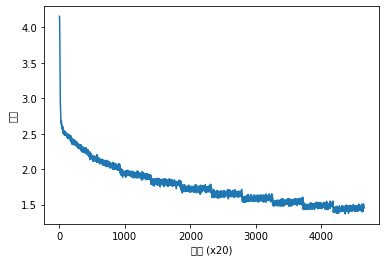

In [11]:
# 학습이 완료되었기 때문에, SKIP

# vocab_size = len(word_to_id)

# contexts, target = create_contexts_target(corpus, window_size)

# model = CBOW(vocab_size, hidden_size, window_size, corpus)
# optimizer = Adam()
# trainer = Trainer(model, optimizer)

# trainer.fit(contexts, target, max_epoch, batch_size)
# trainer.plot()

# word_vecs = model.word_vecs
# params = {}
# params['word_vecs'] = word_vecs.astype(np.float16)
# params['word_to_id'] = word_to_id
# params['id_to_word'] = id_to_word
# pkl_file = 'cbow_params.pkl'
# with open(pkl_file, 'wb') as f:
#     pickle.dump(params, f, -1)

In [12]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [35]:
analogy('queen','king','lady',word_to_id, id_to_word, word_vecs)


[analogy] queen:king = lady:?
 man: 5.7578125
 professor: 5.28125
 friend: 5.00390625
 letter: 4.94140625
 guy: 4.8984375


In [36]:
analogy('good','best','bad',word_to_id, id_to_word, word_vecs)


[analogy] good:best = bad:?
 worst: 3.994140625
 notion: 3.703125
 rest: 3.619140625
 disabilities: 3.5625
 moment: 3.525390625


In [37]:
analogy('take','taken','be',word_to_id, id_to_word, word_vecs)


[analogy] take:taken = be:?
 been: 5.29296875
 risen: 3.765625
 multiples: 3.521484375
 denominations: 3.498046875
 comparison: 3.48828125


In [38]:
analogy('do','does','have',word_to_id, id_to_word, word_vecs)


[analogy] do:does = have:?
 has: 10.1875
 had: 6.67578125
 've: 4.1640625
 owns: 3.650390625
 holds: 3.33203125


In [39]:
analogy('tokyo','japan','beijing',word_to_id, id_to_word, word_vecs)


[analogy] tokyo:japan = beijing:?
 pricings: 5.40234375
 china: 4.75
 cambodia: 4.453125
 arabia: 4.39453125
 a.m: 4.34765625


In [ ]:
analogy('queen','king','lady',word_to_id, id_to_word, word_vecs)
analogy('good','best','bad',word_to_id, id_to_word, word_vecs)
analogy('take','taken','be',word_to_id, id_to_word, word_vecs)

In [ ]:
analogy('france','paris','germany',word_to_id, id_to_word, word_vecs)


In [17]:
word_vecs[word_to_id['man']]

array([ 1.346  ,  0.08075, -0.4155 , -1.646  ,  0.6025 ,  0.437  ,
       -0.7163 , -0.387  , -1.284  ,  0.929  ,  1.619  ,  0.3623 ,
        0.2732 , -0.6353 ,  0.369  , -1.076  ,  0.717  , -0.8613 ,
       -0.6226 ,  0.2048 ,  0.06555, -0.02458, -0.6387 ,  1.371  ,
        1.02   ,  0.02826,  0.4775 , -0.1965 , -1.685  , -0.2607 ,
       -0.6445 , -0.709  ,  0.05148, -0.2186 , -0.3035 ,  0.05884,
        1.134  , -0.788  ,  0.764  ,  0.2496 ,  0.359  , -0.2327 ,
       -0.6274 ,  0.1238 ,  0.7954 , -0.304  ,  0.35   , -1.064  ,
       -0.687  , -0.561  , -1.54   ,  0.8423 ,  0.0656 ,  0.8276 ,
        0.4475 , -0.946  , -2.148  ,  1.008  ,  1.047  ,  1.254  ,
        0.2664 , -1.604  ,  1.165  , -0.3147 ,  0.3494 , -0.274  ,
       -0.12415,  0.2947 ,  1.465  , -0.145  ,  0.6016 , -2.078  ,
        0.721  ,  1.189  ,  0.0921 , -0.6626 ,  0.7305 ,  0.882  ,
        0.6587 , -1.015  ,  0.5513 , -0.6763 ,  0.9775 ,  1.936  ,
       -0.882  , -0.3433 , -0.8975 , -0.412  , -0.872  , -0.61

In [18]:
word_vecs[word_to_id['woman']]

array([ 0.7754  , -0.039   ,  0.206   , -0.6167  ,  0.469   ,  0.0683  ,
       -0.487   ,  0.563   , -0.7725  ,  0.6064  ,  1.292   ,  0.578   ,
        0.515   , -0.7246  ,  1.207   , -0.4568  ,  0.7925  , -0.719   ,
        0.571   ,  1.084   , -0.008064, -0.73    , -0.428   ,  1.341   ,
        0.4358  ,  0.01688 ,  0.4758  , -0.02022 , -1.675   , -0.993   ,
       -0.69    ,  0.2184  ,  0.517   , -0.0804  , -0.1192  , -0.9385  ,
        0.2573  , -0.05878 ,  1.126   , -0.571   ,  0.197   , -0.629   ,
       -1.42    ,  0.3794  ,  0.4473  , -0.08264 , -0.4258  , -1.417   ,
       -0.9443  , -0.3137  , -2.21    ,  0.0885  ,  0.3943  ,  0.9507  ,
        0.1947  , -0.3706  , -1.15    ,  0.671   ,  0.9854  ,  1.68    ,
        0.2028  , -1.031   ,  1.431   ,  0.11456 , -0.2255  , -0.548   ,
       -1.239   , -0.4998  ,  0.711   ,  0.1362  ,  1.128   , -1.75    ,
        0.1244  ,  0.344   ,  0.6543  ,  0.2009  , -1.218   ,  1.398   ,
        0.4614  , -0.28    ,  0.1154  ,  0.2308  , 

In [19]:
a = word_vecs[word_to_id['lady']] - word_vecs[word_to_id['man']]
a

array([-0.498   , -0.6943  ,  0.2255  ,  1.562   , -0.04053 , -0.1967  ,
       -0.68    , -0.926   ,  0.563   , -0.8145  , -0.3154  , -0.695   ,
        0.1504  ,  0.593   , -0.3037  ,  0.6763  , -0.0415  , -0.08984 ,
        0.063   ,  0.8438  ,  0.10974 , -0.2676  ,  0.2068  , -0.6963  ,
       -0.2554  , -0.4175  , -0.001953, -0.4006  ,  1.06    , -0.4824  ,
       -0.288   , -0.4307  ,  0.1786  , -0.11365 ,  0.547   , -0.2544  ,
       -0.6724  ,  0.582   , -0.0825  , -0.84    ,  0.0762  , -0.7773  ,
        0.907   , -0.1833  , -0.592   ,  0.9355  , -0.1927  ,  1.006   ,
       -0.0669  , -0.006348,  0.609   , -0.1665  , -0.476   ,  0.0869  ,
        0.283   ,  0.441   ,  1.134   , -0.753   , -0.4214  , -0.539   ,
       -0.4595  ,  0.4365  ,  0.1211  ,  0.6567  , -0.8486  , -0.5264  ,
       -0.0873  , -0.5684  , -0.376   ,  0.2974  , -0.9043  ,  1.447   ,
       -0.8745  , -0.2866  ,  0.4343  ,  0.1602  , -1.125   , -0.1904  ,
        0.08496 , -0.1621  , -0.1978  ,  0.6235  , 

In [20]:
b = word_vecs[word_to_id['queen']] - word_vecs[word_to_id['king']]
b

array([-0.5913 , -0.4229 , -0.1133 , -0.508  , -0.227  , -0.4697 ,
       -0.0371 ,  0.456  , -2.137  , -0.507  , -0.809  , -0.3894 ,
       -0.7637 , -0.4714 , -0.9287 ,  0.429  , -1.201  ,  0.3623 ,
       -0.1581 ,  0.6646 ,  0.2013 , -1.067  ,  0.6416 , -0.1964 ,
       -1.213  , -0.6245 , -0.3113 ,  0.124  ,  1.414  ,  0.3584 ,
       -0.2249 ,  0.08154,  0.271  ,  0.2598 ,  0.415  , -0.3271 ,
       -0.8213 ,  1.146  ,  0.6523 ,  0.0762 ,  0.1254 ,  1.225  ,
       -0.3306 ,  0.1731 , -0.4565 , -0.0454 , -0.4707 ,  0.5513 ,
       -0.4907 , -0.1744 , -0.9707 ,  0.6553 , -0.439  , -0.2678 ,
       -0.616  , -0.7817 ,  0.6064 ,  0.2551 , -1.182  , -0.2712 ,
        0.2822 ,  1.855  , -0.598  ,  0.7017 ,  0.1506 , -0.3953 ,
        0.7715 ,  0.6934 , -0.911  , -0.3962 , -0.321  ,  1.113  ,
       -0.0536 , -0.01807, -0.0857 , -1.252  , -0.575  , -0.1758 ,
       -0.1434 , -0.03662,  0.649  , -0.3765 , -0.633  , -0.839  ,
        0.02148, -0.8623 , -0.8433 ,  0.562  ,  0.2524 ,  0.44

In [21]:
np.sum(np.square(a))

35.3

In [22]:
np.sum(np.square(b))

43.84

In [23]:
np.sum(np.square(a-b))

60.4

In [24]:
word_vecs[word_to_id['king']].shape

(100,)